# Y pseudo-alignment to determine founder donors

Imports.

In [1]:
import matplotlib.pyplot as plt # make simple visualizations
import pandas as pd # data management

import genotype_helpers # genotype processing
import io_helpers # file I/O

from genotype_helpers import Genotypes # type hinting


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This genotype helper file adds:
NumPy version 1.24.3,
pyMSAviz version 0.4.0,
scikit-allel version 1.3.6



Constants.

In [2]:
y_groups = io_helpers.load_haplogroups('Y')
y1_modern_ids = y_groups.index[y_groups == 'Y1']
y2_modern_ids = y_groups.index[y_groups == 'Y2']

# order in which founders appear in Fig 1A from nj_trees.ipynb
y1_founder_names = ['BN', 'MR', 'ACI']
y2_founder_names = ['WN', 'BUF', 'WKY', 'M520', 'F344']

Helper functions

In [3]:
def get_consensus_row(df: pd.DataFrame) -> pd.Series: return df.mode().loc[0]

def plot_num_deviants(geno: Genotypes, haplotype: str, ax: plt.Axes, 
                      tag: str) -> None:
    """Make and save a plot of deviations from the consensus.

    The plot show position along chromosome vs. number of samples
    with a (nonmissing) non-consensus genotype call.

    Parameters
    ----------
    geno: Genotypes
        Genotypes as a (samples x variants) shape data frame.
    haplotype: str
        Name of this modern haplotype.
    ax: plt.Axes
        Axes to plot on.
    tag: str
        Letter to use as a panel tag on the top left.
    """
    
    # mismatches + NAs minus NAs leaves just mismatches
    num_deviants = (~geno.eq(get_consensus_row(geno))).sum() - geno.isna().sum()

    ax.scatter(range(geno.shape[1]), num_deviants)
    ax.set_xticks([])

    ax.set_title(f'{haplotype} rats deviating from consensus')
    ax.set_xlabel('Position along chrY')
    ax.set_ylabel(f'Count of {haplotype} rats')

    io_helpers.write_panel_tag(tag, -0.1, 1.15, ax=ax)

Load genotypes as when making groups, but keep in SNPs with MAF=0. 
This retains variants which are fixed in modern samples.

In [4]:
y_modern = genotype_helpers.get_genotypes(
    genotype_helpers.SHALLOW_MODERN_FILE, 'Y', format='nucleotide',

    use_maf_filter=False
    )

Read 5227 variants across 15120 samples
7637 samples removed for not being male
Filtering out 300 variants for INFO score < 0.5
Filtering out 670 variants for % nonmissing calls < 75
Filtering out 10 samples for % nonmissing calls < 50
Genotypes for 7473 rats across 4257 variants


In [5]:
y_founders = genotype_helpers.get_genotypes(
    genotype_helpers.FOUNDERS_FILE, 'Y', format='nucleotide',
    
    variant_subset=y_modern.columns, use_maf_filter=False, use_miss_filter=False
    )

Read 18499 variants across 8 samples
0 samples removed for not being male
14242 variants removed for not being in the given subset
Genotypes for 8 rats across 4257 variants


Subset founder genotypes to intra-haplogroup SNPs.

In [6]:
y1_vary = genotype_helpers.filter_maf(y_founders.loc[y1_founder_names])
y2_vary = genotype_helpers.filter_maf(y_founders.loc[y2_founder_names])

Filtering out 4232 variants for MAF=0
Filtering out 4240 variants for MAF=0


Compare modern consensus haplotypes to the founders at intra-haplogroup SNPs.

In [7]:
y1_modern_haplo = get_consensus_row(y_modern.loc[y1_modern_ids])
y1_vary.eq(y1_modern_haplo.loc[y1_vary.columns]).all(axis=1)

BN     False
MR      True
ACI     True
dtype: bool

In [8]:
y2_modern_haplo = get_consensus_row(y_modern.loc[y2_modern_ids])
y2_vary.eq(y2_modern_haplo.loc[y2_vary.columns]).all(axis=1)

WN      False
BUF     False
WKY     False
M520     True
F344    False
dtype: bool

Pseudo-alignments.

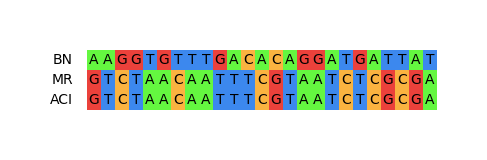

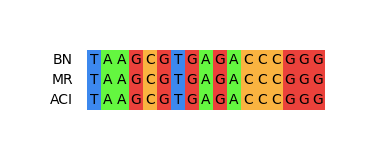

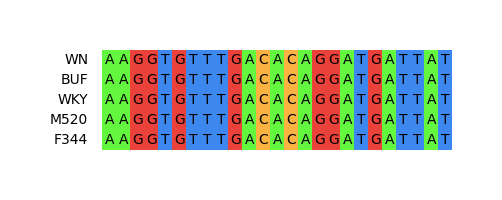

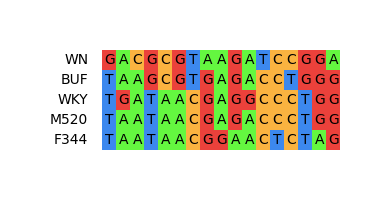

In [9]:
for name_group in ['Y1', 'Y2']:
    names = y1_founder_names if name_group == 'Y1' else y2_founder_names
    for vary_pos_group in ['Y1', 'Y2']:
        pos = y1_vary.columns if vary_pos_group == 'Y1' else y2_vary.columns
        basename = f'{name_group}_founders_{vary_pos_group}_vary_pos'
        fig = genotype_helpers.plot_align(y_founders.loc[names, pos], 
                                          basename=basename)
        io_helpers.save_plot(basename, figure=fig)

Check for devation from the consensus haplotypes. This is *Figure S7*.

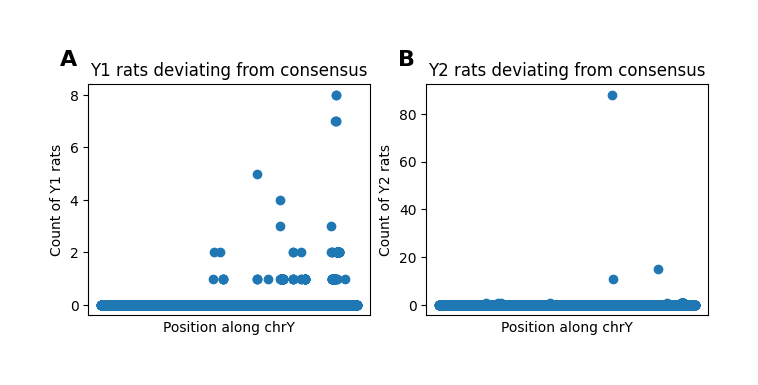

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plot_num_deviants(y_modern.loc[y1_modern_ids], 'Y1', ax1, tag='A')
plot_num_deviants(y_modern.loc[y2_modern_ids], 'Y2', ax2, tag='B')

fig.set_size_inches(8, 3)
io_helpers.save_plot('Y_deviants', extension='png')

Find SNPs between the modern consensuses.

In [11]:
y_modern_haplos = pd.concat([y1_modern_haplo, y2_modern_haplo], axis=1).T
y_snps = genotype_helpers.filter_maf(y_modern_haplos)

# format for VCF
y_snps.index = ['REF', 'ALT']
y_snps = y_snps.T.reset_index(names='POS')
genotype_helpers.write_snp_vcf(y_snps, 'Y')
y_snps

Filtering out 127 variants for MAF=0


,POS,REF,ALT,#CHROM,ID,QUAL,FILTER,INFO
0,6860,T,C,NC_051357.1,Y:6860,50,PASS,.
1,7004,G,A,NC_051357.1,Y:7004,50,PASS,.
2,13169,C,A,NC_051357.1,Y:13169,50,PASS,.
3,18030,T,C,NC_051357.1,Y:18030,50,PASS,.
4,21091,G,A,NC_051357.1,Y:21091,50,PASS,.
...,...,...,...,...,...,...,...,...
4125,18285155,T,A,NC_051357.1,Y:18285155,50,PASS,.
4126,18285249,T,G,NC_051357.1,Y:18285249,50,PASS,.
4127,18287038,A,T,NC_051357.1,Y:18287038,50,PASS,.
4128,18292245,A,C,NC_051357.1,Y:18292245,50,PASS,.
